In [1]:
import os


In [2]:
! pwd

/aiffel/aiffel/dktc


In [3]:
! pip install transformers

In [4]:
import transformers

In [5]:
transformers.logging.set_verbosity_info

<function transformers.utils.logging.set_verbosity_info()>

In [6]:
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

In [9]:
torch.cuda.is_available()  #GPU가 torch 캐치 가능 

True

In [10]:
torch.cuda.get_device_name(0)  #지금 잡은 device뭔지 보여줌 

'Tesla T4'

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=5)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [12]:
type(tokenizer), type(model)

(transformers.models.bert.tokenization_bert_fast.BertTokenizerFast,
 transformers.models.bert.modeling_bert.BertForSequenceClassification)

In [14]:
torch.cuda.empty_cache()

In [15]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

**언어모델 및 Tokenizer 불러오기**

**데이터셋 가져오기**

In [17]:
data_path = "merged_df_4000.csv"
data = pd.read_csv(data_path)
data.head()

,Unnamed: 0,class,conversation
0,0,일반 대화,휴일이니...쉬게해주세요내말이 ... ㅜㅜ 너무 가기 싫어
1,1,일반 대화,물고기 잡아 올리는 것도 할 수 있어?하하 응 그게 묘미더라 물고기 잡혔을 때 ㅎ/...
2,2,기타 괴롭힘 대화,야 이새끼 봐바 오타쿠인가봐\n 뭔데뭔데 아 뭐냐 그림. 이게 그 미미쨩인가 그거냐...
3,3,일반 대화,"그랬는데, 내가 몰래 여사친 만나다가 여자친구한테 걸려서... 여자친구가 울면서 헤..."
4,4,기타 괴롭힘 대화,야.근데.이렇게 하는거 맞아.???\n맞다고 병신아!!\n야 근데 왜 자꾸 욕해.?...


In [18]:
# class 대화 라벨링하기

data['class'].unique()
class_labels = {"협박 대화":0, "기타 괴롭힘 대화":1, "갈취 대화": 2, "직장 내 괴롭힘 대화":3, "일반 대화": 4}
data['label'] = data['class'].map(class_labels)

In [19]:
data.head()

,Unnamed: 0,class,conversation,label
0,0,일반 대화,휴일이니...쉬게해주세요내말이 ... ㅜㅜ 너무 가기 싫어,4
1,1,일반 대화,물고기 잡아 올리는 것도 할 수 있어?하하 응 그게 묘미더라 물고기 잡혔을 때 ㅎ/...,4
2,2,기타 괴롭힘 대화,야 이새끼 봐바 오타쿠인가봐\n 뭔데뭔데 아 뭐냐 그림. 이게 그 미미쨩인가 그거냐...,1
3,3,일반 대화,"그랬는데, 내가 몰래 여사친 만나다가 여자친구한테 걸려서... 여자친구가 울면서 헤...",4
4,4,기타 괴롭힘 대화,야.근데.이렇게 하는거 맞아.???\n맞다고 병신아!!\n야 근데 왜 자꾸 욕해.?...,1


여기서 작은 모델만 training 하는 거니까 len 작게만...0.1만 뽑겠당.

In [20]:
len(data)

7950

In [21]:
sampled_data = data.sample(frac=0.05, random_state=2024)

In [22]:
sampled_data['label'].value_counts()

4    196
0     57
1     52
2     51
3     42
Name: label, dtype: int64

In [23]:
#결측치 확인
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 3832 to 2389
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    398 non-null    int64 
 1   class         398 non-null    object
 2   conversation  398 non-null    object
 3   label         398 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 15.5+ KB


In [24]:
#중복값 확인
sampled_data[sampled_data['conversation'].duplicated()]

,Unnamed: 0,class,conversation,label


In [25]:
#중복값 제거
#sampled_data.drop_duplicates(subset = ['conversation'], inplace = True)

In [26]:
# def remove_null_conversations(dataframe):
#     # 'conversation_split' 열의 null 값 찾기
#     null_conversations = dataframe[dataframe['conversation_split'].isnull()]

#     # null 값이 있는지 확인하고, 있다면 해당 행 제거
#     if not null_conversations.empty:
#         dataframe = dataframe.dropna(subset=['conversation_split'])

#     return dataframe

# 함수 호출
cleaned_data = sampled_data

# # 결과 확인
# cleaned_data['label'].value_counts()

## BERT 불러오기

In [27]:
X_data = cleaned_data['conversation']
y_data = cleaned_data['label']

In [28]:
TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 2024
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)  #stratify하면 데이터 분리 이전의 라벨별 비율을 고려해 데이터 분리

In [29]:
X_train

2645    야 너 눈 안보이냐?\n응 나 앞이 안보여\n장님이네 야 따라와봐\n눈이 안보여서 ...
2573                      가을 즐기기엔 너무 짧았지.다음주엔 외출을 좀 해야겠어.
4570    ? 예상이 가지? 대화를 하러 왔어.\n 눈을 가리고 의자에 묶어둔 채로?\n 거절...
6932                           샤오미도 품질 좋아?좋다기보단 가성비 좋은편이야
4486    씨는 좋겠다?\n네?\n애인도 있고 집도 있고 차도 있고. 히야 부러워\n아닙니다....
                              ...                        
5515    네 여보세요? 최세정씨 맞으시죠\n네 맞는데 무슨일이죠?\n다름이 아니라 공중 화장...
1376    지금 또 청소기 돌렸어요? 다들 퇴근후 쉬어야하는 시간인데 너무 시끄럽네요\n 아니...
742                  축구할 때 포지션이 어디야?나는 다 뛰는데 미드필드를 제일 좋아해
1128           오호 ㅋㅋ 정보 ㄳㄳ 그래야겠다 ㅋㅋㅋㅋ 지성이면 수분크림 많이 발라줘야겠다
2087    그러니까 시키는 일만 했어야지\n어디를 더 부러뜨려 줄까\n시키는대로 했잖아!\n그...
Name: conversation, Length: 318, dtype: object

In [30]:
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()
y_train_list = y_train.tolist()
y_test_list = y_test.tolist()

In [31]:
print(type(X_train_list))

<class 'list'>


In [32]:
dic = {0: "협박 대화", 1:"기타 괴롭힘 대화", 2:"갈취 대화", 3:"직장 내 괴롭힘 대화", 4:"일반 대화"}
ans_train = torch.tensor(y_train_list)

In [33]:
def create_batches(input_list, output_list, batch_size):
  assert len(input_list) == len(output_list)
  for i in range(0, len(input_list), batch_size):
        yield (input_list[i:i + batch_size], output_list[i:i + batch_size])

BATCH_SIZE = 8  # You can adjust this as needed

In [38]:
# 런타임 1분 소요
# 활성화 함수 AdamW 불러오기
from transformers import AdamW

# 활성화 함수 AdamW 인스턴스화
optimizer = AdamW(model.parameters(), lr=0.05)

# 모델을 학습 모드로 변경
model.train()

# 에포크 수 지정 및 손실을 담은 빈 컨테이너 리스트 생성
epochs =1
losses = []

# 파인튜닝
for epoch in range(epochs):
    for batch, labels in create_batches(X_train_list, ans_train, BATCH_SIZE):
        inputs = tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        labels = labels.to(device)
        # 그래디언트(기울기) 초기화
        optimizer.zero_grad()
        # 변수 eval_list에 담긴 여섯 개 문장을 토크나이저에 넣고 인코딩
        #inputs = tokenizer.batch_encode_plus(X_train_list, return_tensors="pt", padding=True, truncation=True)
        # 위에서 생성된 input 변수에 담긴 키(key)와 키값(value)을 **inputs 형식(**kwargs 형식)으로 모델에 전달
        # 거기에 추가로 labels를 텐서 타입으로 모델에 전달
        outputs = model(**inputs, labels=labels)
        # 로짓 추출
        logits = outputs.logits

        # 손실 추출
        loss = outputs.loss

        # 오차역전파
        loss.backward()

        # 가중치(weight) 업데이트
        optimizer.step()

        # 손실을 빈 컨테이너 losses에 순서대로 저장
        losses.append(loss)

        # 에포크 및 손실 값 출력
        # 에포크는 0부터 시작하기에, 1을 더해줘서 사람들이 에포크 회수를 더 자연스럽게 인지하게 조치
        print(f"epoch:{epoch+1}, loss:{loss}")

    # 에폭당 평균 손실 계산 및 출력
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"epoch:{epoch+1}, average loss:{avg_epoch_loss}")

epoch:1, loss:5.661579132080078
epoch:1, loss:23.87445831298828
epoch:1, loss:20.362987518310547
epoch:1, loss:66.4600830078125
epoch:1, loss:86.92110443115234
epoch:1, loss:27.869606018066406
epoch:1, loss:14.180756568908691
epoch:1, loss:7.319157123565674
epoch:1, loss:20.188993453979492
epoch:1, loss:25.542627334594727
epoch:1, loss:10.18469524383545
epoch:1, loss:21.663721084594727
epoch:1, loss:12.672140121459961
epoch:1, loss:16.545392990112305
epoch:1, loss:68.350341796875
epoch:1, loss:21.380517959594727
epoch:1, loss:13.71363353729248
epoch:1, loss:9.785932540893555
epoch:1, loss:29.871612548828125
epoch:1, loss:29.66653060913086
epoch:1, loss:19.735458374023438
epoch:1, loss:4.408719539642334
epoch:1, loss:14.945531845092773
epoch:1, loss:14.425537109375
epoch:1, loss:40.574920654296875
epoch:1, loss:11.316981315612793
epoch:1, loss:8.54213809967041
epoch:1, loss:17.299060821533203
epoch:1, loss:10.84618091583252
epoch:1, loss:56.50577926635742
epoch:1, loss:15.99284362792968

NameError: name 'epoch_losses' is not defined

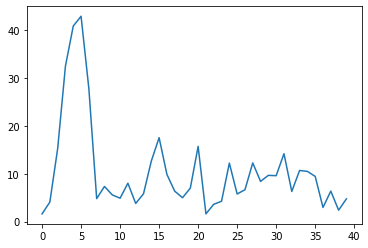

In [36]:
new_losses = [i.item() for i in losses]
import matplotlib.pyplot as plt
plt.plot(new_losses);


In [40]:
# 파인 튜닝 이후 추론
# 모델을 eval 모델로 전환
model.eval()

# 모델 예측을 담을 preds라는 빈 컨테이너 리스트 생성
preds = []

# 이하 코드의 설명은 문제 45 코드 참조
with torch.no_grad():
  for sentence in X_test_list:
    inputs = tokenizer.encode(sentence, return_tensors="pt",padding=True, truncation=True)
    inputs = inputs.to(device)
    outputs = model(inputs)
    logits = outputs.logits
    pred = logits.argmax(-1).item()
    logits = logits.detach().cpu().numpy()
    preds.append(logits.argmax(-1).item())
    print(f"{dic[pred]}:{sentence}")


일반 대화:요즈음 다 저걸로 홍보하더라나도 당장 사야겠다/나 맨날 지저분하게 지워져서 스트레스였어
일반 대화:야 야 내가 좀 춥다 환절기 되니까 좀 쌀쌀해 그렇지?
어어? 그러네
와 이새끼 패딩 좋은거 입고 다니네
아 고마워
아니 고마워말고 좀 벗어봐
응?
나도 한번 입어보자
어? 입어만 보는거지?
응 입어보니까 보는 것만으로도 다르네 야 이거 내가 지금 추우니까 입고 다음주에 돌려줄게
어?안되는데
야 그럼 내가 추워 얼어 죽었으면 좋겠냐??
.아니. 그건아닌데
그럼 주말 잘보내라 나 간다
일반 대화:오 신발샀냐?
응. 전에 신던게 다 헤져서.부모님이 사주셨어.
니네 집 꽤 사나보다? 이런 신발도 잘 사주시고?
응.? 그런건 아닌데.그래도 신발은 오래 신는 거라고.
잠깐 벗어봐. 나 한 번만 신어보자.
어.돌려줄거지.?
아 장난치냐 내가 그럼 니가 신 던거 가져갈까봐 그래? 빨리 내놔보라고.
잠깐만이야.
와 이거 딱 내 신발이네. 야 나 이거 몇일만 빌려주라 내가 신으니까 니가 신을 때보다 더 간지나잖아. 고맙다 잘 신을게
돌려줘.! 정말 안돼.저번에도 너가 빌려갔다가.다 헤져서 산 거란 말이야.
일반 대화:나는 아몬드 봉봉 제일 좋아해아몬드 봉봉도 인기 좋지 ㅋㅋ/난 후식은 상큼한 게 좋더라구
일반 대화:아니 나한테 송아지를 넘기기로 했으면서 이제와서 무슨말인가
아 저기 옆마을 한씨가 더 비싸게 쳐주기로한다지 뭔가
아니 그래도 사람이 약속한 게 있지!
약속은먼저 했는데 나도 돈이 궁해서 그랬네 미안하네
미안하다고 하면 단가?
그럼 어쩌라고? 내가 뭐 무릎이라고 꿇고 빌어야하나?
하. 진짜 적반하장이고만 내가 이대로 물러날것같은가?
안그러면 어쩌려고?
그 송아지 못팔게 내가 지금 낫으로 막 찔러 죽여블거구만
뭣이야? 나도 가만 있을지 알고? 나도 자네집 소들 다 죽여블거구만
일반 대화:넌 어디 아픈데 없어?난 요즘 시력이 안좋아져서 걱정이야ㅠㅠ/안과 추천 좀 해줘
일반 대화:물고기 잡아 올리는 것도 할 수 있어?하하 응 그게 묘미더라 물고기 잡혔을 때 ㅎ/매력

In [47]:
ans = torch.tensor(y_test_list)
preds = torch.tensor(preds)
print(f"Accuracy:{100 * sum(ans.detach().clone()==preds)/len(ans.detach().clone())}%")

Accuracy:48.75%


/tmp/ipykernel_185/2313815014.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(preds)
